## 5 Feature Engineering und Feature preperation

- Relevante Features aus Rohdaten erstellt

- Was ist schon passiert:
    - recoding der variable relevent_experience
    - erzeugen von: experience_ord, last_new_job_ord / Ordnung erzeugt
    - erstellen einer 'no Answer' option als Kategorie in gender, enrolled_university, education_level, major_discipline, company_size, company_type


1) Ordnung in variablen bringen
- [ ] company_size / -> Datenprobleme (später problem in Notebook 3. beheben)
Klassen ab 1000 zusammenfassen lassen

2) Missingness als Kategorie
- [x]

3) Kardinalität beseitigen wenn kritisch und auch seltene Labels
- wenn es zu viele Klassen und zu kleine Klassen gibt, zusammenlegen
- [x] -> profiling report und entscheiden
- [ ] City Klassen zusammenfassen / welche Klassen würdet Ihr zusammenfügen und warum

4) Skalierung der numerischen Features
- [ ] anfang mit standard Skaler, alternative min-max Skaler

5) neue Features
- [x] -- erstmal keine

6) Encoding 
- [ ] One-Hot 
- [x] Ordinal Encoding / experience_ord, last_new_job_ord 
    - erstmal entscheidung eductaion_level nicht dem ordnal encoding zu unterziehen

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling  
import missingno as msno
from scipy.stats import pearsonr

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Zielverzeichnis (bitte anpassen)
TARGET_DIR = r"/Users/danielmini/Projekte/data_analyics26/data_analytics_master/2_data_acquisition/processed_data"

# CSV-Datei finden und laden
csv_files = [f for f in os.listdir(TARGET_DIR) if f.endswith(".csv")]
df = pd.read_csv(os.path.join(TARGET_DIR, csv_files[0]))

print("DataFrame geladen:", df.shape)

DataFrame geladen: (19158, 14)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   company_size            19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  training_hours          19158 non-null  int64  
 11  target                  19158 non-null  float64
 12  experience_ord          19158 non-null  float64
 13  last_new_job_ord        19158 non-null  float64
dtypes: float64(4), int64(3), object(7)
mem

## 1) Ordnung in Variablen bringen

In [4]:
# Repariere company_size Klassen
df['company_size'] = df['company_size'].replace({
    '10/49': '10-49',
    '100-500': '100-499',
    '500-999': '500-999',
    '1000-4999': '1000+',
    '5000-9999': '1000+',
    '10000+': '1000+'
})

print("company_size Klassen nach Reparatur:")
print(df['company_size'].value_counts())

company_size Klassen nach Reparatur:
company_size
No Answer    5938
1000+        3910
50-99        3083
100-499      2571
10-49        1471
<10          1308
500-999       877
Name: count, dtype: int64


## 2) Missingness als Kategorie
- [x]

## 3) Kardinalität beseitigen wenn kritisch und auch seltene Labels
- wenn es zu viele Klassen und zu kleine Klassen gibt, zusammenlegen
- [x] -> profiling report und entscheiden
- [ ] City Klassen zusammenfassen / welche Klassen würdet Ihr zusammenfügen und warum

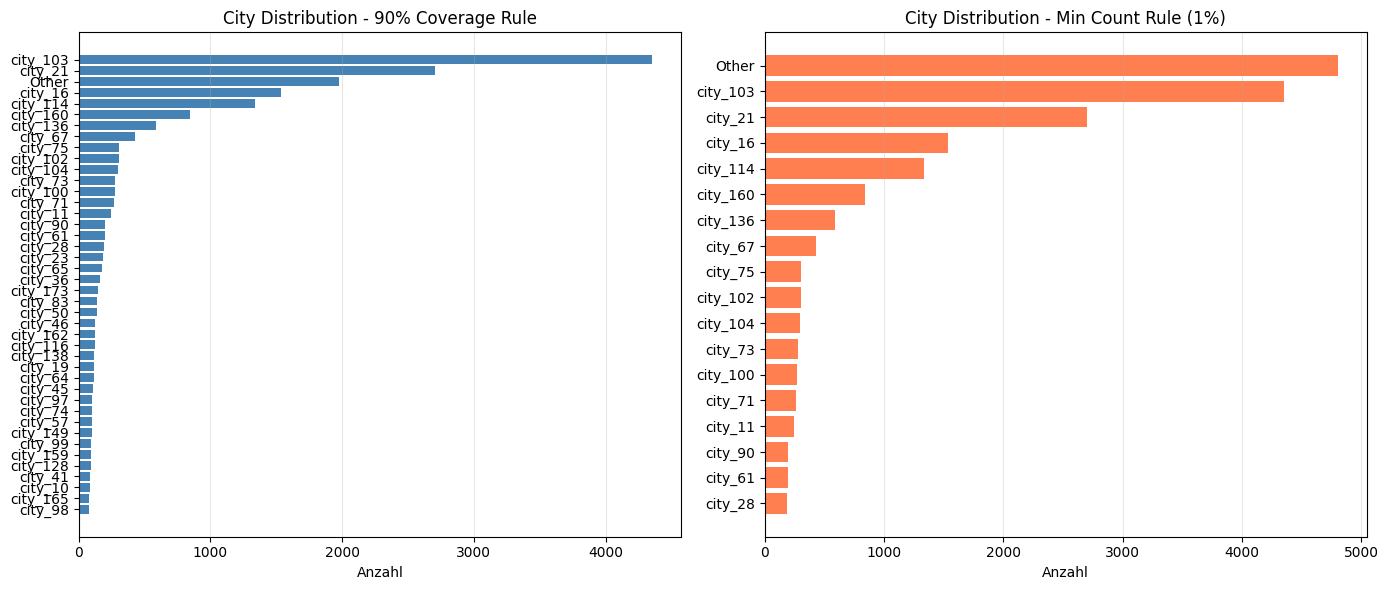


90% Coverage: 41 Cities + Other
Min Count Rule: 17 Cities + Other


In [ ]:
# City Coverage Analyse und Mapping

# 1. City Coverage von 90%
city_counts = df['city'].value_counts()
city_cumsum = city_counts.cumsum() / city_counts.sum()
cities_90 = city_cumsum[city_cumsum <= 0.90].index.tolist()

# Neue Variable mit 90% Coverage
df['city_90coverage'] = df['city'].apply(lambda x: x if x in cities_90 else 'Other')

# 2. Min Count Rule - Cities mit < 1% zusammenfassen
total_count = len(df)
min_threshold = total_count * 0.01
cities_min_count = city_counts[city_counts >= min_threshold].index.tolist()

df['city_mincount'] = df['city'].apply(lambda x: x if x in cities_min_count else 'Other')

# 2 Horizontal Barcharts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: 90% Coverage
city_90_counts = df['city_90coverage'].value_counts().sort_values()
axes[0].barh(city_90_counts.index, city_90_counts.values, color='steelblue')
axes[0].set_xlabel('Anzahl')
axes[0].set_title('City Distribution - 90% Coverage Rule')
axes[0].grid(axis='x', alpha=0.3)

# Chart 2: Min Count Rule (1%)
city_mincount_counts = df['city_mincount'].value_counts().sort_values()
axes[1].barh(city_mincount_counts.index, city_mincount_counts.values, color='coral')
axes[1].set_xlabel('Anzahl')
axes[1].set_title('City Distribution - Min Count Rule (1%)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n90% Coverage: {len(cities_90)} Cities + Other")
print(f"Min Count Rule: {len(cities_min_count)} Cities + Other")

In [6]:
# Ersetze die ursprüngliche City-Variable mit der Min Count Rule
df['city'] = df['city_mincount']


In [7]:
# Entferne die Spalten city_90coverage und city_mincount aus df_scaled und df_encoded
df = df.drop(columns=['city_90coverage', 'city_mincount'])

## 4) Skalierung der numerischen Features
- [ ] anfang mit standard Skaler, alternative min-max Skaler


In [8]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude binary columns (0 and 1 only) and enrollee_id
binary_cols = [col for col in numeric_cols if set(df[col].unique()) <= {0, 1, 0.0, 1.0}]
cols_to_scale = [col for col in numeric_cols if col not in binary_cols and col != 'enrollee_id']

print(f"Binary columns (excluded from scaling): {binary_cols}")
print(f"Columns to scale: {cols_to_scale}")

# --- Scale without overwriting original df ---
scaler = StandardScaler()
df_scaled = df.copy()

df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

print("\nScaled columns statistics:")
print(df_scaled[cols_to_scale].describe())

# --- Helper: inverse transform back to original scale ---
def inverse_scale_numeric(df_like: pd.DataFrame, scaler: StandardScaler, cols: list[str]) -> pd.DataFrame:
    """
    Returns a copy where `cols` are inverse-transformed back to original scale.
    Assumes df_like[cols] are in the same order as when scaler was fit.
    """
    out = df_like.copy()
    out[cols] = scaler.inverse_transform(out[cols])
    return out

# Example usage after clustering:
# df_back = inverse_scale_numeric(df_scaled, scaler, cols_to_scale)

Binary columns (excluded from scaling): ['relevent_experience', 'target']
Columns to scale: ['city_development_index', 'training_hours', 'experience_ord', 'last_new_job_ord']

Scaled columns statistics:
       city_development_index  training_hours  experience_ord  \
count            1.915800e+04    1.915800e+04    1.915800e+04   
mean            -3.464072e-16   -7.640244e-17    1.205378e-16   
std              1.000026e+00    1.000026e+00    1.000026e+00   
min             -3.087326e+00   -1.071765e+00   -1.492306e+00   
25%             -7.202420e-01   -7.054460e-01   -9.010834e-01   
50%              6.011096e-01   -3.058249e-01   -1.620554e-01   
75%              7.389193e-01    3.768610e-01    8.725839e-01   
max              9.740064e-01    4.506279e+00    1.611612e+00   

       last_new_job_ord  
count      1.915800e+04  
mean       3.449237e-17  
std        1.000026e+00  
min       -1.189292e+00  
25%       -5.881348e-01  
50%       -5.881348e-01  
75%        6.141793e-01  
max

## 5) neue Features
- [x] -- erstmal keine

## 6) Encoding 
- [ ] One-Hot 
- [x] Ordinal Encoding / experience_ord, last_new_job_ord 
    - erstmal entscheidung eductaion_level nicht dem ordnal encoding zu unterziehen

In [9]:
# One-Hot Encoding der nominalen Variablen (ohne Zielvariable und numerische Features)
nominal_cols = [
    'city', 'gender', 'enrolled_university', 'education_level',
    'major_discipline', 'company_size', 'company_type'
]

# One-Hot Encoding durchführen
df_encoded = pd.get_dummies(df_scaled, columns=nominal_cols, drop_first=True)

In [10]:

# Speichern des neuen Datensatzes im processed_data-Verzeichnis
output_path = os.path.join(TARGET_DIR, "scaled_encoded_data.csv")
df_encoded.to_csv(output_path, index=False)

print(f"One-Hot-encoded und skalierter Datensatz gespeichert unter:\n{output_path}")

One-Hot-encoded und skalierter Datensatz gespeichert unter:
/Users/danielmini/Projekte/data_analyics26/data_analytics_master/2_data_acquisition/processed_data/scaled_encoded_data.csv


In [11]:
df_encoded.head(10)

,enrollee_id,city_development_index,relevent_experience,training_hours,target,experience_ord,last_new_job_ord,city_city_100,city_city_102,city_city_103,...,company_size_50-99,company_size_500-999,company_size_<10,company_size_No Answer,company_type_Funded Startup,company_type_NGO,company_type_No Answer,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,0.738919,1,-0.488985,1.0,1.611612,-0.588135,False,False,True,...,False,False,False,True,False,False,True,False,False,False
1,29725,-0.428410,0,-0.305825,0.0,0.724778,1.816493,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,11561,-1.660590,0,0.293607,0.0,-0.753278,-1.189292,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,33241,-0.323026,0,-0.222571,1.0,-1.492306,-1.189292,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,666,-0.501368,1,-0.955209,0.0,1.611612,1.215336,False,False,False,...,True,False,False,False,True,False,False,False,False,False
5,21651,-0.525687,1,-0.688795,1.0,0.133556,-0.588135,False,False,False,...,False,False,False,True,False,False,True,False,False,False
6,28806,0.738919,1,-0.688795,0.0,-0.753278,-0.588135,False,False,False,...,True,False,False,False,True,False,False,False,False,False
7,402,-0.541900,1,-0.788700,1.0,0.429167,1.816493,False,False,False,...,False,False,True,False,False,False,False,False,False,True
8,27107,0.738919,1,-0.322476,1.0,-0.457667,-0.588135,False,False,True,...,True,False,False,False,False,False,False,False,False,True
9,699,0.738919,1,0.959642,0.0,1.020389,1.816493,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [13]:
df_encoded.shape

(19158, 53)

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   enrollee_id                           19158 non-null  int64  
 1   city_development_index                19158 non-null  float64
 2   relevent_experience                   19158 non-null  int64  
 3   training_hours                        19158 non-null  float64
 4   target                                19158 non-null  float64
 5   experience_ord                        19158 non-null  float64
 6   last_new_job_ord                      19158 non-null  float64
 7   city_city_100                         19158 non-null  bool   
 8   city_city_102                         19158 non-null  bool   
 9   city_city_103                         19158 non-null  bool   
 10  city_city_104                         19158 non-null  bool   
 11  city_city_11   